In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import statistics


In [81]:
position = ["position_x","position_y","position_z"]
target= ["target_position_x","target_position_y","target_position_z"]
total_time = "time"

max_distance_error = 4.0
max_height_error = 3*max_distance_error/4
max_contraction_error = 1.0
#position_x,position_y,position_z,target_position_x,target_position_y,target_position_z,time,extension,target_extension,height_error,distance_to_waypoint,extension_error,reaching_height_time

In [3]:
os.getcwd()
os.chdir('..\Bidirectional_interface\Assets\Logs')



In [4]:
folders = ['Raw', 'Visual', 'Glove', 'Bracelets']
for folder in folders:
    try:
        os.mkdir(folder)
    except:
        print("Folder", folder, "already existing")

Folder Raw already existing
Folder Visual already existing
Folder Glove already existing
Folder Bracelets already existing


In [5]:
def get_contraction_time(file):
    data = pd.read_csv(file)
    index = next(i for i, j in enumerate(data['3rd_waypoint_time'].to_list()) if j)
    data['contraction_time'].iloc[-1] =  data['time'].iloc[-1] - data['time'][index]
    data.to_csv(file)



In [6]:
d = os.listdir('Visual')
d

['.~lock.3_29_19_sub3_Visual.csv#',
 '1_14_48_sub1_Visual.csv',
 '2_13_44_sub2_Visual.csv',
 '3_29_19_sub3_Visual.csv',
 '4_27_10_sub4_Visual.csv']

In [7]:
all_mixed_files = glob.glob("*.csv")

In [8]:
def move_in_correct_folder(filename):
    if "drone" in filename :
        newfilename = "Raw" +"\\" + filename
        os.replace(filename, newfilename)    
    else:
        types_of_feedback = ["Visual", "Glove", "Bracelets"]
        for fb_type in types_of_feedback:
            if fb_type in filename :
                newfilename = fb_type +"\\" + filename
                os.replace(filename, newfilename)
                

def organise_logs(all_files):
    all_files =  glob.glob("*.csv")
    for file in all_files:  
        move_in_correct_folder(file)
    


Put the files in the correct folders

In [9]:
organise_logs(all_mixed_files)

In [10]:
def get_total_times(all_files):
    time_dict = {}
    for file in all_files:
        data = pd.read_csv(file)
        time_dict[file] = []
        time_dict[file].append(data["time"].iloc[-1])
    return time_dict

def get_reaching_waypoint_times(all_files):
    waypoint_times = ["1st_waypoint_time", "2nd_waypoint_time","3rd_waypoint_time"]
    time_dict = {}
    for file in all_files:
        data = pd.read_csv(file)
        time_dict[file] = []
        for wpt_time in waypoint_times:
            time_dict[file].append(data[wpt_time].iloc[-1])
    return time_dict

def get_ext_contr_times(all_files):
    ext_contr_times = ['extension_time', 'contraction_time']
    time_dict = {}
    for file in all_files:
        get_contraction_time(file)
        data = pd.read_csv(file)
        time_dict[file] = []
        for time in ext_contr_times:
            time_dict[file].append(data[time].iloc[-1])
    return time_dict


def to_time_array_list(times_dict):
    nb_of_time = len(next(iter(times_dict.values())))
    
    times_list = np.empty((nb_of_time, 0)).tolist()
    
    for times_for_1_subj in times_dict:
        for i in range(nb_of_time):
            times_list[i].append((times_dict[times_for_1_subj][i]))
    array_list = []
    for sublist in times_list:
        array_list.append(np.asarray(sublist))
    return array_list


def get_mean_and_std_times(all_times_dict):
    #waypts_times : dictionnary, containing time to reach each waypoint for each file/subject
    array_list = to_time_array_list(all_times_dict)

    mean_list = [np.mean(i) for i in array_list]
    stdev_list = [np.std(i) for i in array_list]
    return  mean_list, stdev_list, array_list

In [11]:
def get_execution_times(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    total_time = get_total_times(files)
    waypoint_times = get_reaching_waypoint_times(files)
    extraction_contraction_times = get_ext_contr_times(files)
    
    return [total_time, waypoint_times, extraction_contraction_times]
    

In [13]:

#total time, waypoints time, extension-contraction time
visual_times = get_execution_times("Visual")

glove_times = get_execution_times("Glove")

brac_times = get_execution_times("Bracelets")



In [ ]:
to_time_arrays(visual_times[1])

In [21]:
visual_times[0]

{'Visual\\1_14_48_sub1_Visual.csv': [176.6062],
 'Visual\\2_13_44_sub2_Visual.csv': [137.8038],
 'Visual\\3_29_19_sub3_Visual.csv': [152.2547],
 'Visual\\4_27_10_sub4_Visual.csv': [131.8534]}

In [14]:
def plot_mean_and_std(times):
    i = 0
    for type_of_time in times:
        if i == 0:
            title = "Time for the overall experiment"
        elif i==1:
            title = "Time to reach each waypoint"
        elif i==2:
            title = "Time for extension and contraction"
        i+=1
        _,_,data = get_mean_and_std_times(type_of_time)    
        fig = plt.figure(figsize=(12, 4))
        fig, ax = plt.subplots()
        ax.boxplot(data)
        ax.set_xlabel('Waypoint n°')
        ax.set_ylabel('Time [s]')
        plt.title(title)
        
def plot_height(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_y"])
        plt.plot(data["target_position_y"]+1)
        plt.plot(data["target_position_y"]+1+np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(data["target_position_y"]+1-np.ones(len(data["height_error"]))*0.1*max_height_error)
        
        plt.title("Height")
        plt.figure()
        plt.plot(data["height_error"])
        plt.plot(np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(np.ones(len(data["height_error"]))*(-0.1*max_height_error))
        plt.plot(np.zeros(len(data["height_error"])))
        
def plot_x_distance(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_x"])
        plt.plot(data["target_position_x"])
        plt.plot(data["target_position_x"]+np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(data["target_position_x"]-np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        
        plt.title("X distance")
        plt.figure()
        plt.plot(data["target_position_x"]- data["position_x"])
        plt.plot(np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_x"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_x"])))
        
def plot_z_distance(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_z"])
        plt.plot(data["target_position_z"])
        plt.plot(data["target_position_z"]+np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(data["target_position_z"]-np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        
        plt.title("z distance")
        plt.figure()
        plt.plot(data["target_position_z"]- data["position_z"])
        plt.plot(np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_z"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_z"])))        
        

    

<Figure size 864x288 with 0 Axes>

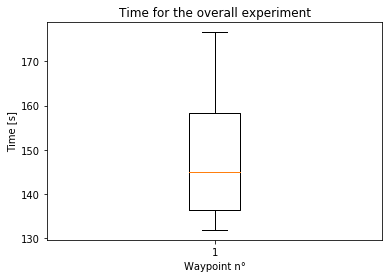

<Figure size 864x288 with 0 Axes>

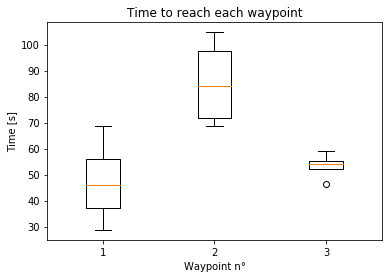

<Figure size 864x288 with 0 Axes>

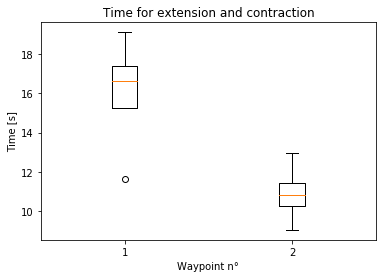

<Figure size 864x288 with 0 Axes>

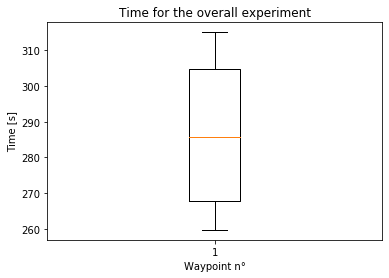

<Figure size 864x288 with 0 Axes>

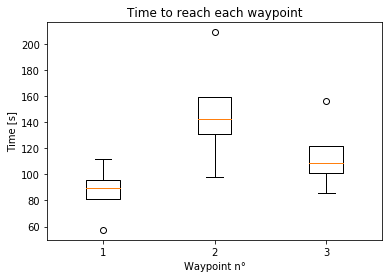

<Figure size 864x288 with 0 Axes>

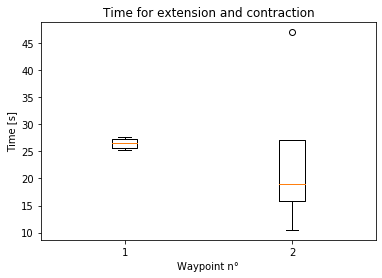

<Figure size 864x288 with 0 Axes>

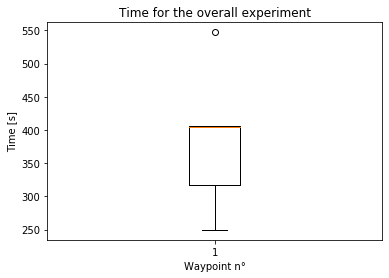

<Figure size 864x288 with 0 Axes>

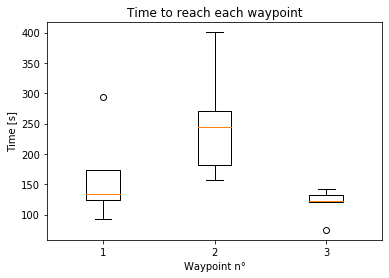

<Figure size 864x288 with 0 Axes>

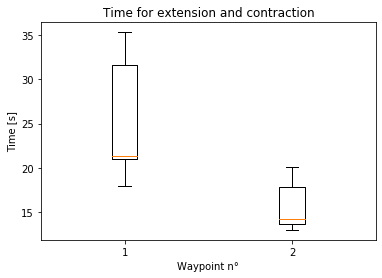

In [15]:
plot_mean_and_std(visual_times)
plot_mean_and_std(glove_times)
plot_mean_and_std(brac_times)


In [ ]:
plot_z_distance("Bracelets")

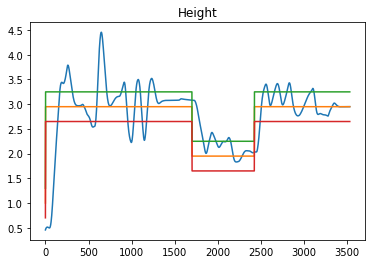

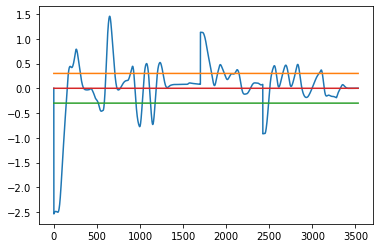

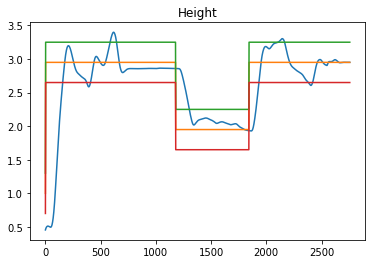

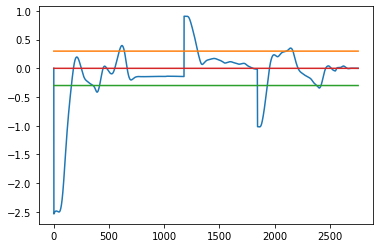

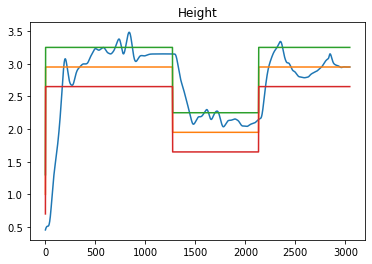

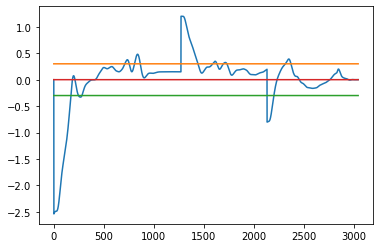

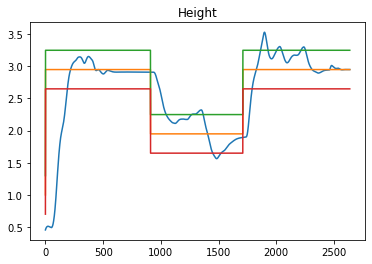

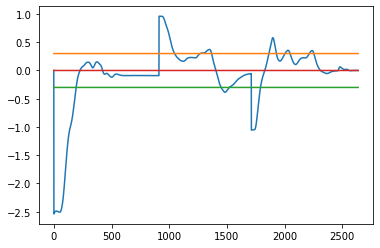

In [33]:
plot_height("Visual")

In [79]:
def get_overshoot_count(error_list, max_error):
    wasOk = False
    overshoot_count = 0
    for point in error_list:
        if point > 0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        elif point < -0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        else: wasOk = True
    return overshoot_count-1 # - 1 because at the begining, it is not an overshoot

def get_overshoot_count_mean_and_std(feedback_type, error_type):
    #error_type is a string: height_error, x_error, y_error, extension_error
    error_list = []
    max_error = 0
    
    overshoot_list = []
    
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        if error_type == "height_error":
            error_list = data["height_error"]
            max_error = max_height_error
        elif error_type == "x_error":
            error_list = data["target_position_x"]-data["position_x"]
            max_error = max_distance_error
        elif error_type == "z_error":
            error_list = data["target_position_y"]-data["position_y"]
            max_error = max_distance_error
        elif error_type == "extension_error":
            error_list = data["extension_error"]
            max_error = max_contraction_error
        else : 
            print("incorrect error_type")
            return
        overshoot_list.append(get_overshoot_count(error_list, max_error))
        
    return np.mean(np.asarray(overshoot_list)), np.std(np.asarray(overshoot_list))
    
    

In [76]:
data = pd.read_csv("Visual\\1_14_48_sub1_Visual.csv") 

In [77]:
get_overshoot_count(data["height_error"], max_height_error)

16

In [80]:
get_overshoot_count_mean_and_std("Bracelets", "height_error")

(13.4, 5.535341001239219)

In [ ]:
_,_,test = get_mean_and_std_times(visual_waypoint_times)
for t in test:
    print (t)

In [ ]:
get_mean_and_std_times(visual_total_time)

In [ ]:
mean, stddev = get_mean_and_std_times(visual_waypoint_times)
stddev

In [ ]:
visual_extraction_contraction_times


In [ ]:
get_mean_and_std_times(visual_extraction_contraction_times)

In [ ]:
get_mean_and_std_times(glove_total_time)

In [ ]:
get_mean_and_std_times(glove_extraction_contraction_times)

In [ ]:
get_mean_and_std_times(glove_waypoint_times)

In [ ]:
plt.plot(t,data['position_x'])
plt.plot(t, data['position_y'])
plt.plot(t, data['position_z'])

In [ ]:
plt.plot(data['time'])


In [ ]:
for x in list(data):
    plt.figure()
    plt.plot(data[x])
    plt.title(x)